In [1]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# import chart_studio.tools as tls

In [2]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-22-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-07-22,226.718599,2.044678e+08,226.718599,NaN,NaN,NaN,NaN,NaN
2017-07-23,224.913407,1.442842e+08,225.314561,-1.805192,NaN,NaN,NaN,NaN
2017-07-24,206.810505,3.580211e+08,211.781744,-18.102902,NaN,NaN,NaN,NaN
2017-07-25,200.328556,2.912707e+08,203.546013,-6.481949,NaN,NaN,NaN,NaN
2017-07-26,203.189322,1.557632e+08,203.290748,2.860766,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-20,1488.975794,2.168190e+10,1492.140810,0.000000,61.868846,69.262089,41.973093,27.288996
2022-07-20,1527.413931,2.172813e+10,1517.335896,38.438137,64.019527,73.845298,37.245041,36.600256
2022-07-20,1527.413931,2.168190e+10,1524.534492,0.000000,64.019527,76.594589,31.995466,44.599123


In [3]:
mydf = mydf.dropna()
# display(mydf)


# display(my_data.tail(10))
# mydf.drop(mydf.tail(10).index,
#         inplace = True)
display(mydf)
mydf.corr()

,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-08-24,329.025281,4.519507e+08,326.457443,7.239983,69.654547,20.372867,0.419856,19.953011
2017-08-25,329.865783,3.338393e+08,328.891971,0.840502,69.894479,20.626894,0.539106,20.087788
2017-08-26,343.341337,3.700521e+08,339.212947,13.475555,73.513669,21.665826,1.262431,20.403396
2017-08-27,344.201131,5.198744e+08,342.775936,0.859794,73.730643,22.301488,1.518474,20.783014
2017-08-28,366.809590,7.671665e+08,359.942832,22.608458,78.676407,24.348890,2.852701,21.496189
...,...,...,...,...,...,...,...,...
2022-07-13,1112.920783,1.793689e+10,1098.951561,72.123637,41.988562,-67.788266,17.479501,-85.267768
2022-07-14,1191.130837,1.647422e+10,1164.793901,78.210054,48.359970,-58.631347,21.309137,-79.940484
2022-07-15,1234.099139,1.681719e+10,1214.297642,42.968302,51.511001,-47.361288,26.063357,-73.424645


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
ethereum,1.000000,0.532233,0.999824,0.030610,0.091851,0.185069,-0.002743,0.196870
ethereum_volume,0.532233,1.000000,0.533278,-0.041297,0.235115,0.278609,-0.115095,0.330872
ethereum_ewm,0.999824,0.533278,1.000000,0.012615,0.086098,0.182843,-0.008451,0.196287
ethereum_diff,0.030610,-0.041297,0.012615,1.000000,0.233843,0.073065,0.191527,0.017845
ethereum_rsi,0.091851,0.235115,0.086098,0.233843,1.000000,0.604187,0.394895,0.517163
macd,0.185069,0.278609,0.182843,0.073065,0.604187,1.000000,0.331733,0.956027
macd_h,-0.002743,-0.115095,-0.008451,0.191527,0.394895,0.331733,1.000000,0.040476
macd_s,0.196870,0.330872,0.196287,0.017845,0.517163,0.956027,0.040476,1.000000


In [4]:
mydf.index
mydf['ethereum'].mean()

1067.4288992475865

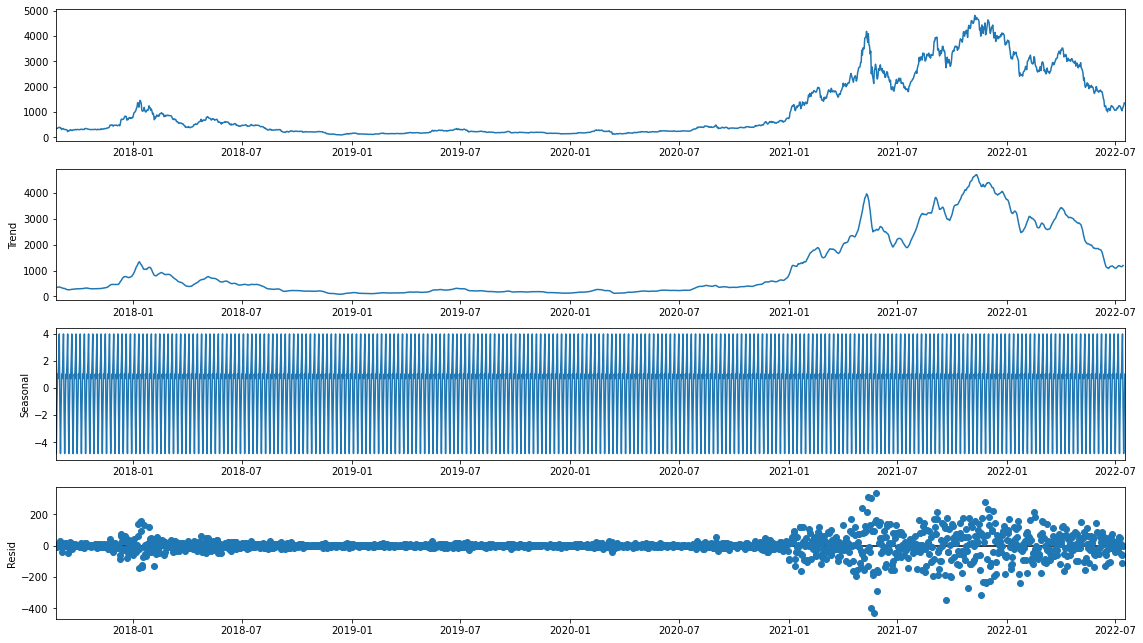

In [5]:
import statsmodels.api
import statsmodels as sm
a = pd.DataFrame(mydf['ethereum'])
res = sm.tsa.seasonal.seasonal_decompose(a,model='additive')
fig = res.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

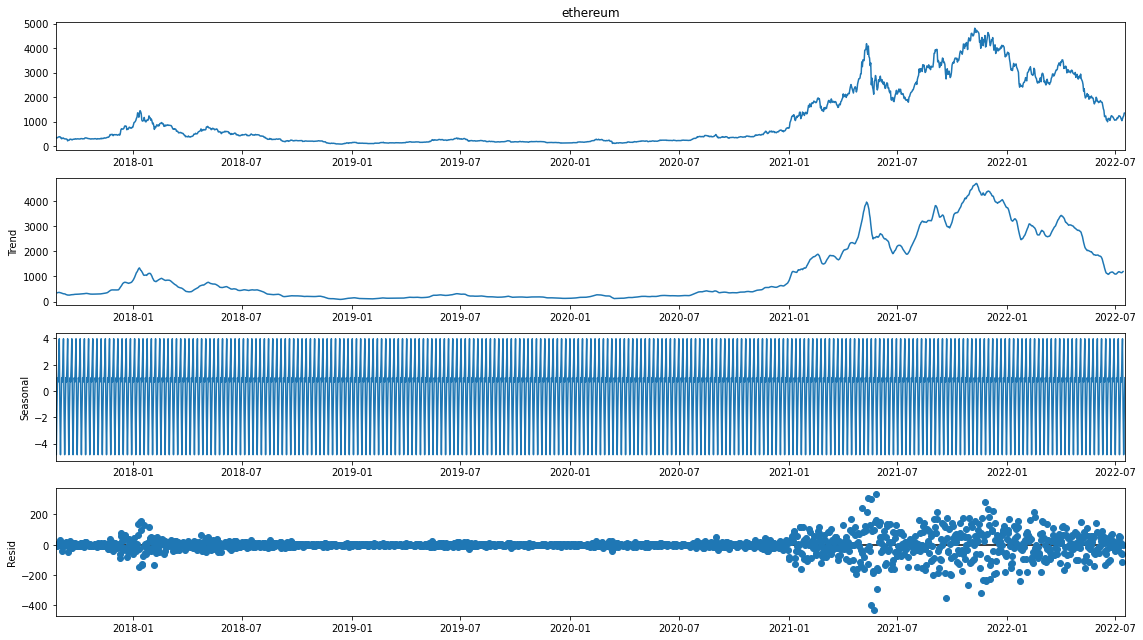

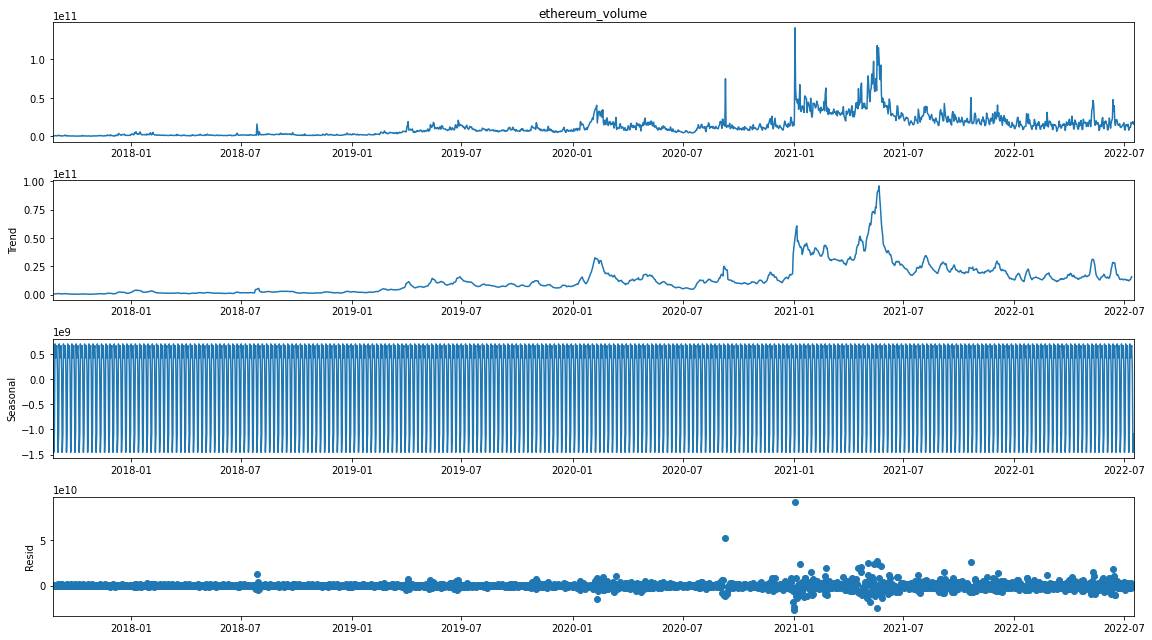

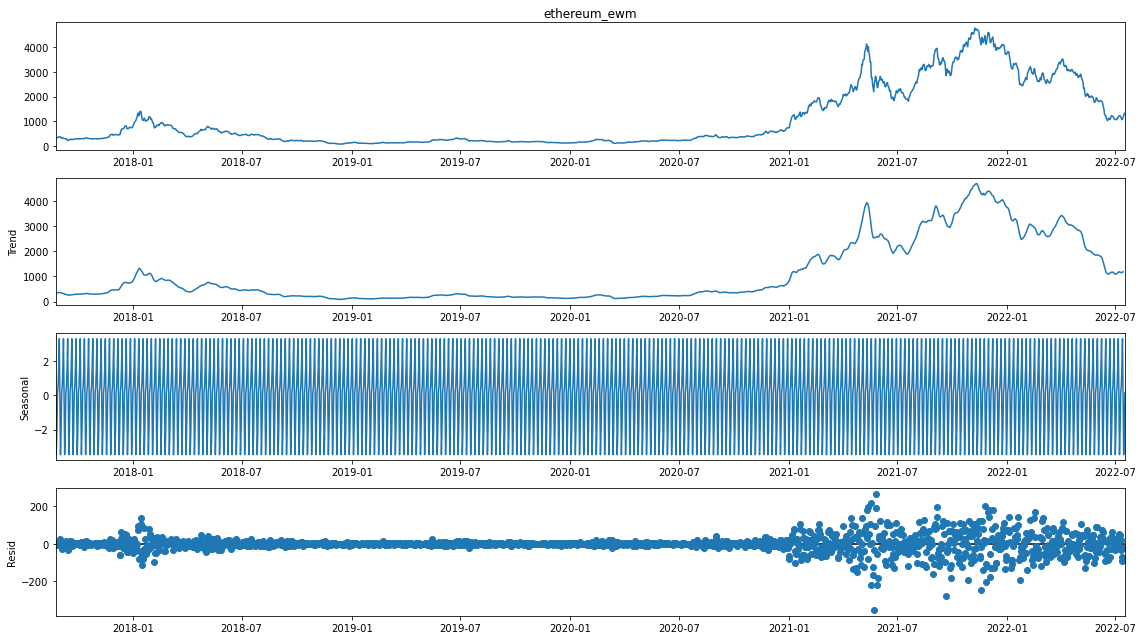

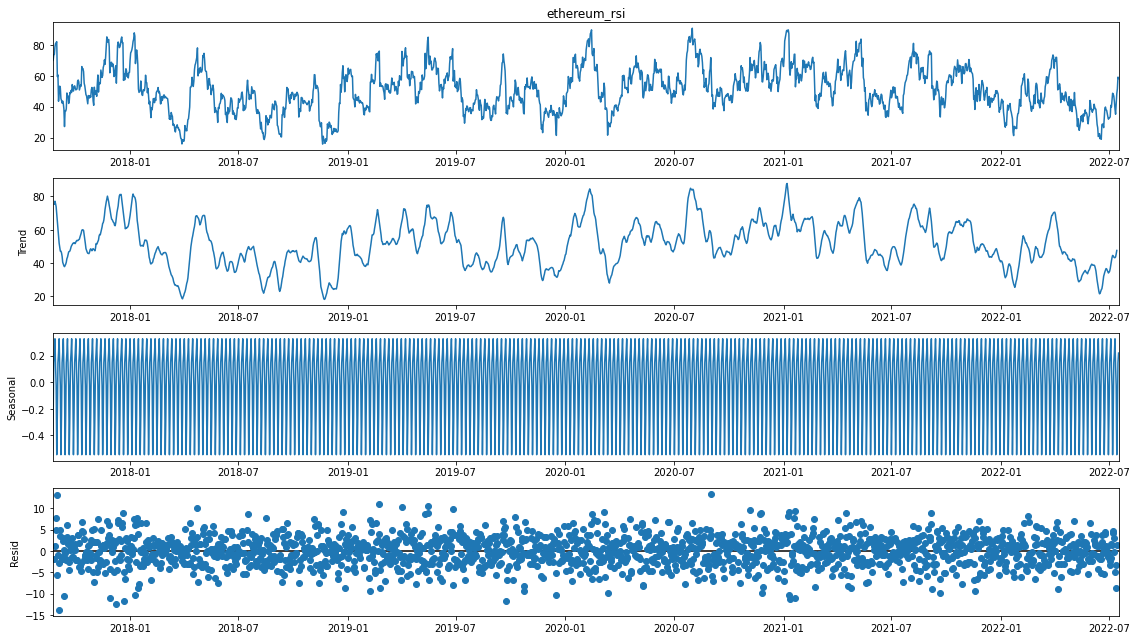

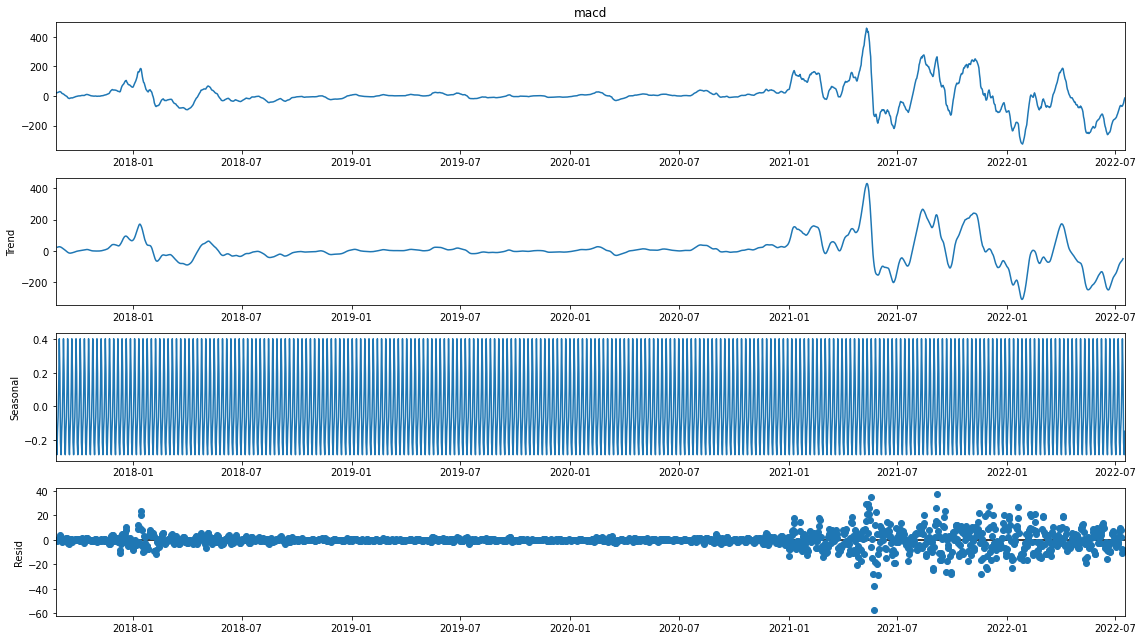

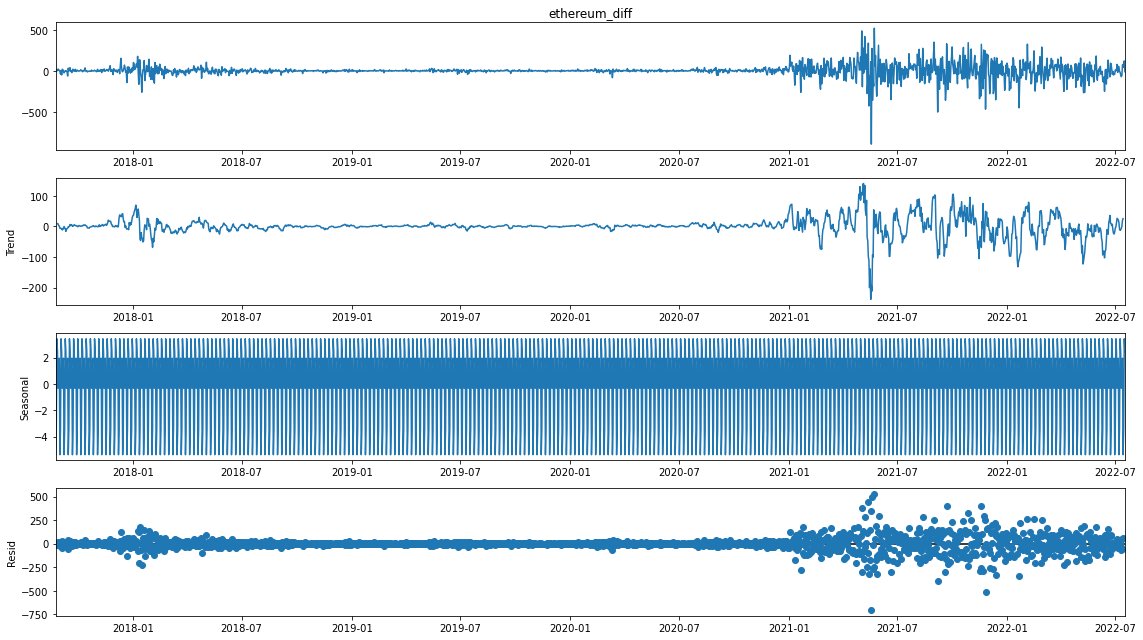

In [6]:


myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']
for i in myCols:
    res = sm.tsa.seasonal.seasonal_decompose(mydf[i],model='additive')
    fig = res.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout()
    plt.show()

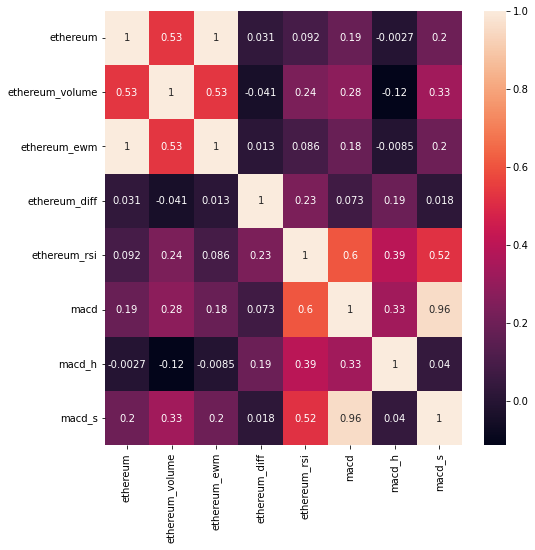

In [7]:
# my_data = mydf[myCols]
# display(mydf)
# mydf.corr()
plt.figure(figsize = (8,8))
sns.heatmap(mydf.corr(), annot=True)
plt.show()

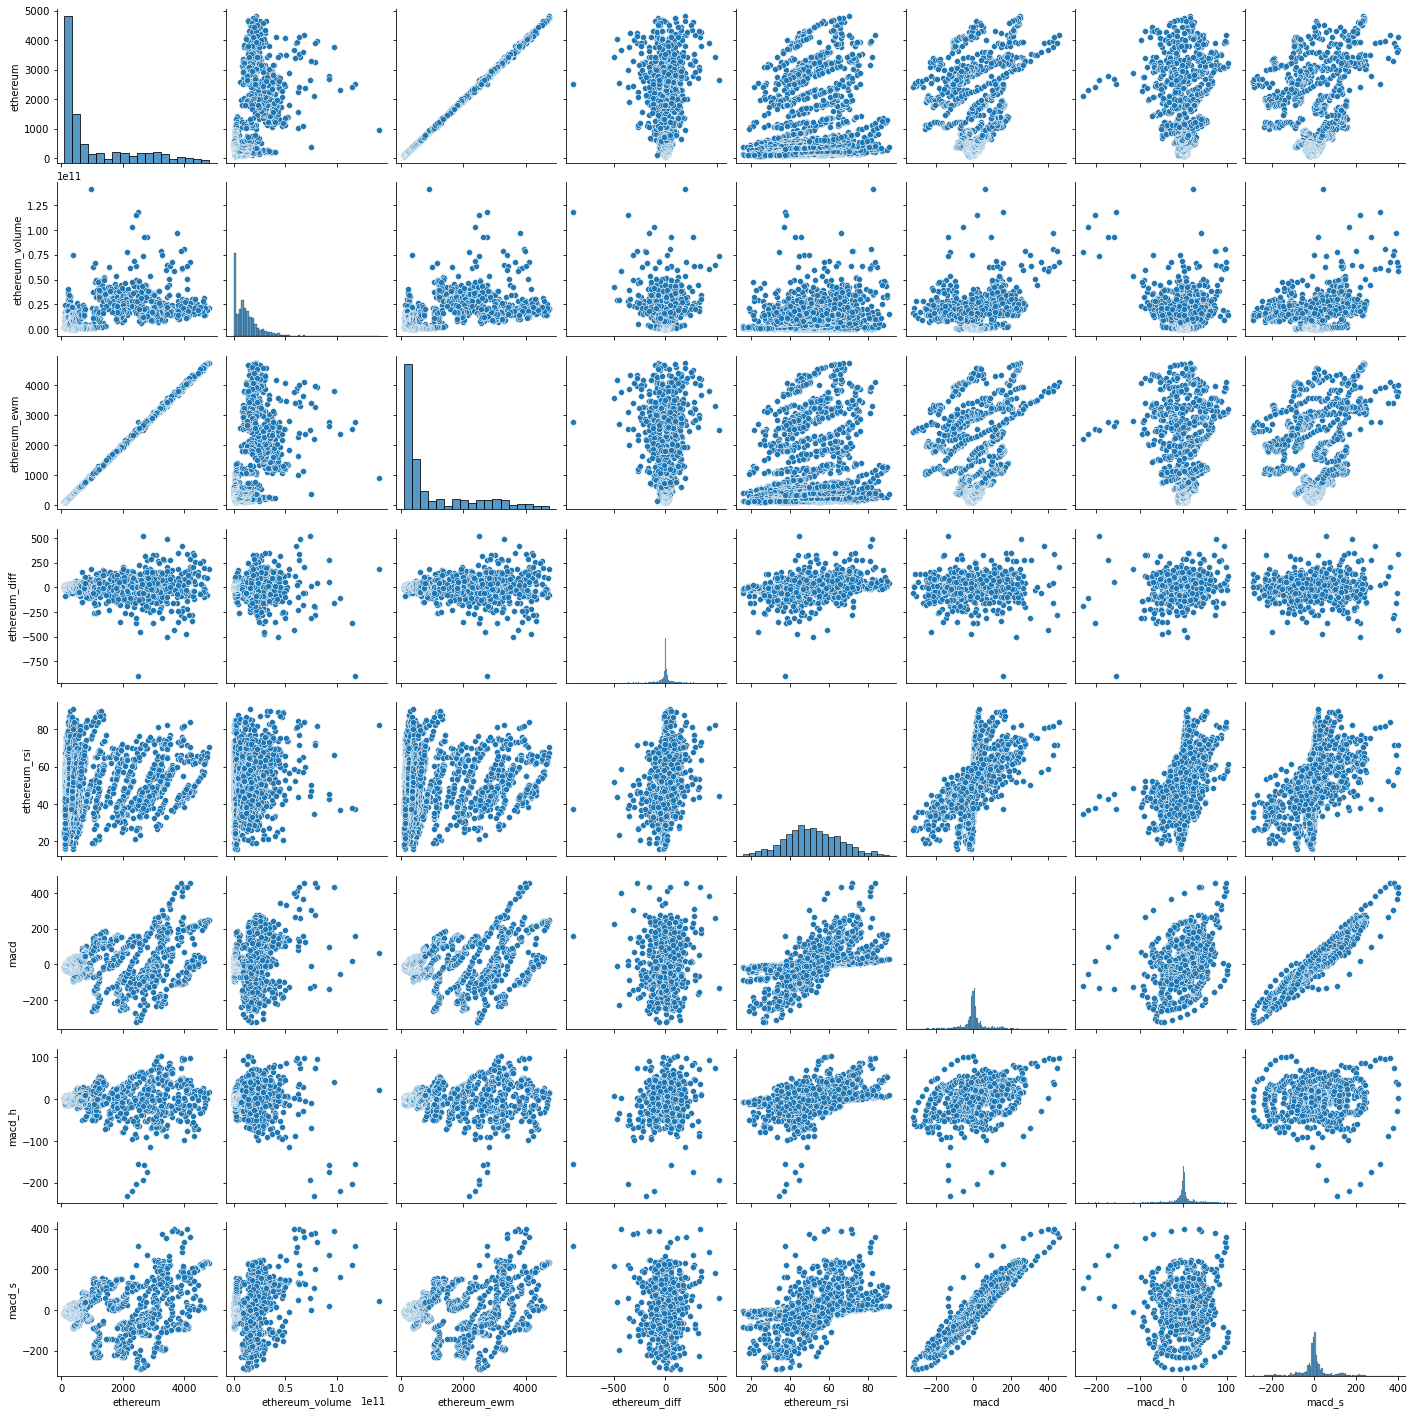

In [8]:
sns.pairplot(mydf)